In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import time
import sys
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from failure_detector import *
from utils.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dl = DataLoader()
dl.load('sample.log')
dl.extractinfo(export=False,single_file=False)

mongodb://localhost:27017/
Database connected


# Sample Log Analysis

In [4]:
ts = {'RCIN':['C1','C2','C3','C4'] ,'AHR2':['Roll','Pitch','Alt','Yaw']}
df,df_corr = corr_var('sample.log',dl,ts)
df_corr.iloc[4:,:4]

,RCIN_C2,RCIN_C3,RCIN_C4,RCIN_C1
AHR2_Pitch,0.631013,-0.227663,0.202982,0.061377
AHR2_Alt,-0.010000,0.303141,-0.105879,-0.009509
AHR2_Roll,-0.018129,-0.030206,0.501776,0.841028
AHR2_Yaw,-0.003648,0.058846,-0.111098,0.060121


In [5]:
ts = {'MODE':['Mode'] ,'ERR':['Subsys']}
df,df_corr = corr_var('sample.log',dl,ts)
df_corr

,MODE_Mode,ERR_Subsys
MODE_Mode,1.000000,-0.522233
ERR_Subsys,-0.522233,1.000000


# All Logs - Mean Correlation - RCIN : AHR2

In [8]:
datalist =os.listdir('../data')

In [ ]:
ts = {'RCIN':['C1','C2','C3','C4'] ,'AHR2':['Roll','Pitch','Alt','Yaw']}
print('File:{} --  {} / {}'.format(datalist[0],0,len(datalist)-1))
d,df_cnc = corr_var(datalist[0][:-4],ts)
df_cnc = df_cnc.iloc[4:,:4]
count_list = []
for i,log in enumerate(datalist[1:]):
    print('File:{} --  {} / {}'.format(log,i+1,len(datalist)-1))
    count_novalues,df_corr = corr_var(log[:-4],dl,ts)
    df_cnc = pd.concat((df_cnc, df_corr.iloc[4:,:4]))
    count_list.append(count_novalues)
#compute the Mean 
by_row_index = df_cnc.groupby(df_cnc.index)
df_means = by_row_index.mean()
df_means

In [ ]:
df_means.dropna(axis=1,how='all')

In [ ]:
print('Mean Number of variables not found in log files : ',np.mean(count_list))

# Top 100 Variables Correlation Table

In [6]:
df = load_top100()
#put the var in the right form for the method input
vardict = load_top100_dict()

In [9]:
#Creating 100x100 correlation table
df_cnc= pd.DataFrame({'temp':[0]}) #init table
time_list = []
for i,log in enumerate(datalist):
    start_time = time.time()
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    _,df_corr = corr_var(log[:-4],dl,vardict)
    df_cnc = pd.concat((df_cnc, df_corr))
    time_list.append((log,os.path.getsize('../data/'+log)/1000000,time.time() - start_time))
by_row_index = df_cnc.groupby(df_cnc.index)
df_means = by_row_index.mean()
df_means.drop([0],inplace=True)
df_means.drop('temp',axis=1,inplace=True)
print(df_means.shape)

File:568c058bb560505c22dc402c.log --  0 / 2607
File:568c0b3a7132fa902e401d31.log --  1 / 2607
File:568c0db17132fa902e401d33.log --  2 / 2607
File:568c0e8f7132fa902e401d34.log --  3 / 2607
File:568c0f4a7132fa902e401d35.log --  4 / 2607
File:56d75dd746a12d150ba9724f.log --  5 / 2607
File:56d7e5a546a12d150ba97250.log --  6 / 2607
File:56f69d8d85e739af3b3cb422.log --  7 / 2607
File:56f6af5385e739af3b3cb424.log --  8 / 2607
File:56f6af5b85e739af3b3cb425.log --  9 / 2607
Time Taken to load correlation Table : 40.999351024627686
(100, 100)


In [12]:
df_means.to_csv('../stats_files/corr_table.csv')

In [13]:
df_means.head()

,ATT_DesPitch,ATT_DesRoll,ATT_DesYaw,ATT_ErrRP,ATT_ErrYaw,ATT_Pitch,ATT_Roll,ATT_TimeMS,ATT_Yaw,BARO_Alt,...,RCIN_C11,RCIN_C12,RCIN_C2,RCIN_C3,RCIN_C4,RCIN_C5,RCIN_C6,RCIN_C7,RCIN_C8,RCIN_C9
ATT_DesPitch,1.000000,-0.050404,-0.243991,0.078713,0.002629,0.581267,-0.053336,0.022224,-0.128078,-0.163596,...,NaN,NaN,0.513955,0.062678,0.086734,-0.170171,0.092614,0.018863,-0.019387,NaN
ATT_DesRoll,-0.050404,1.000000,-0.069843,-0.061309,-0.039137,-0.024661,0.629240,0.009671,-0.007014,-0.011730,...,NaN,NaN,-0.106565,0.058895,0.093518,0.024906,0.014378,-0.028517,0.014615,NaN
ATT_DesYaw,-0.243991,-0.069843,1.000000,-0.024709,0.138467,-0.247325,-0.088221,-0.219370,0.967007,-0.036332,...,NaN,NaN,-0.232371,0.044086,0.060405,0.170852,0.030543,-0.127164,0.001677,NaN
ATT_ErrRP,0.078713,-0.061309,-0.024709,1.000000,0.217629,0.056455,0.060661,0.066695,-0.113167,-0.081837,...,NaN,NaN,0.063129,-0.015000,0.002749,-0.020691,-0.043215,-0.050326,0.015906,NaN
ATT_ErrYaw,0.002629,-0.039137,0.138467,0.217629,1.000000,0.043409,0.108251,0.048976,0.035310,-0.183438,...,NaN,NaN,-0.076211,-0.209075,0.118449,0.077899,-0.173867,-0.039772,-0.045112,NaN


## Graphing Network

In [49]:
df = df_means.copy()
threshold_corr = 0.4
for c in df_means.columns:
    cor_idx = df[c] >=  threshold_corr
    noncor_idx = (df[c] <= threshold_corr) 
    df.loc[cor_idx , c] = 1
    df.loc[noncor_idx , c] = 0

Save corr_networkx_graph.pickle successfully.


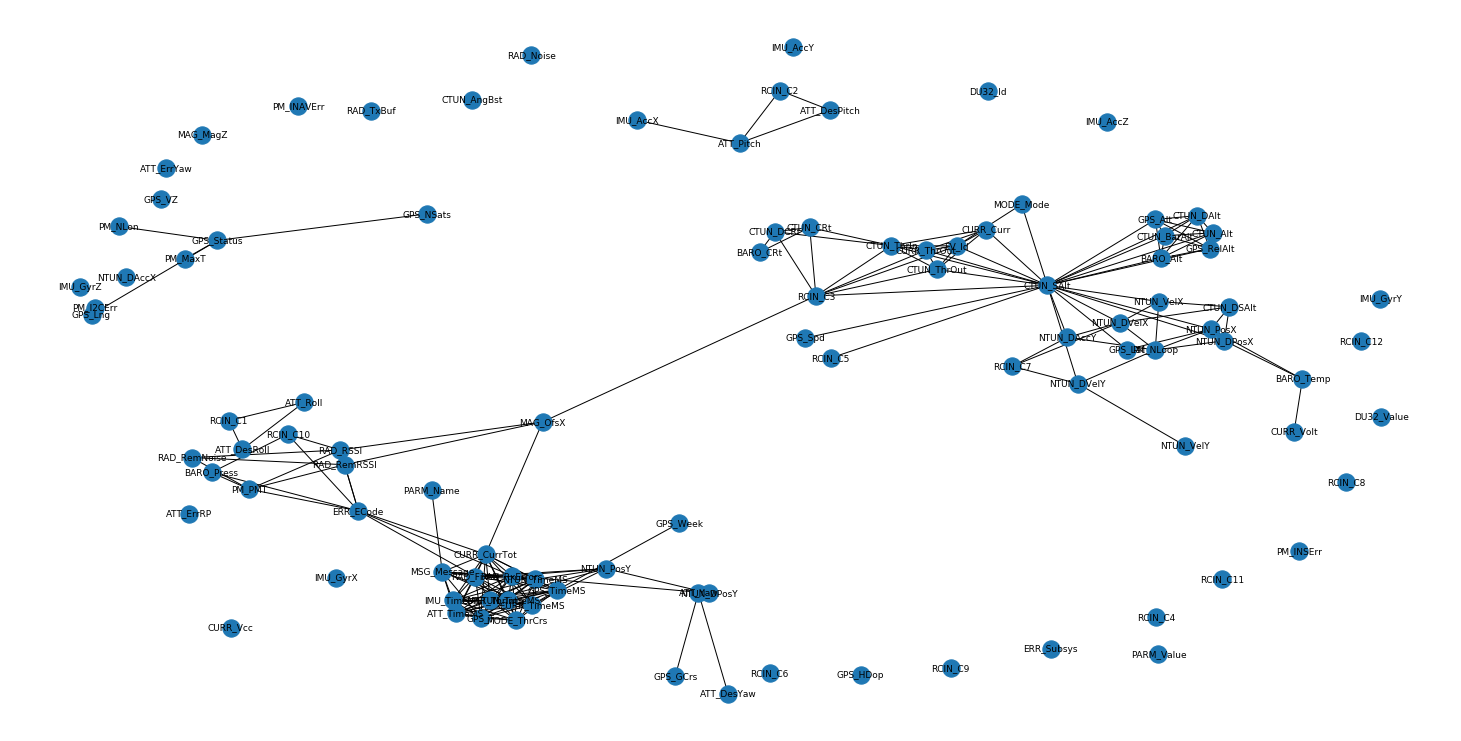

In [53]:
G = nx.Graph()
G.add_nodes_from(df.columns)
for idx in df.index:
    ltuples = [(idx,cl) for cl in df.columns[df.loc[idx] == 1] if cl != idx]
    G.add_edges_from(ltuples)
#create tuples
save_as_pickle(G,'../stats_files','corr_networkx_graph.pickle') #saving the graph to be used later for analysis
pos = nx.spring_layout(G,k=0.3,iterations=50)
plt.figure(figsize=(20,10))
nx.draw(G,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [51]:
stat_in_out = []
for c in df.columns:
    c_count = len(G.edges(c))
    stat_in_out.append((c,c_count))
df_inout = pd.DataFrame(stat_in_out,columns=['signal','corr_count'])

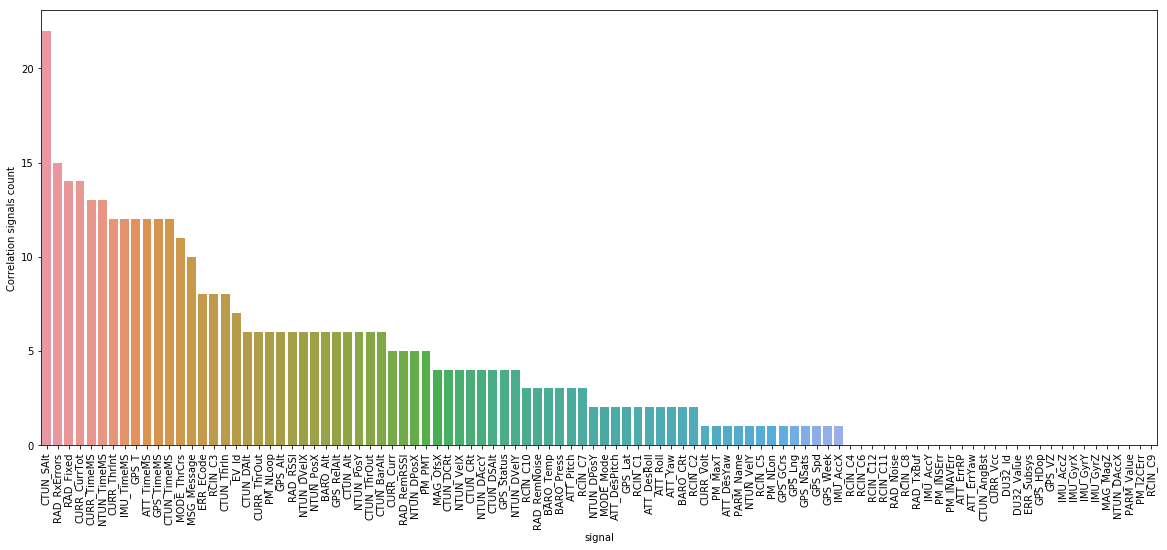

In [52]:
plt.figure(figsize=(20,8))
g = sns.barplot(x='signal',y='corr_count',data=df_inout.sort_values('corr_count',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('corr_count',ascending=False).signal,rotation=90)
plt.ylabel('Correlation signals count')
plt.show()
figure = g.get_figure()  
figure.savefig('../report/correlation_counts.png', dpi=500)